In [1]:
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import utils

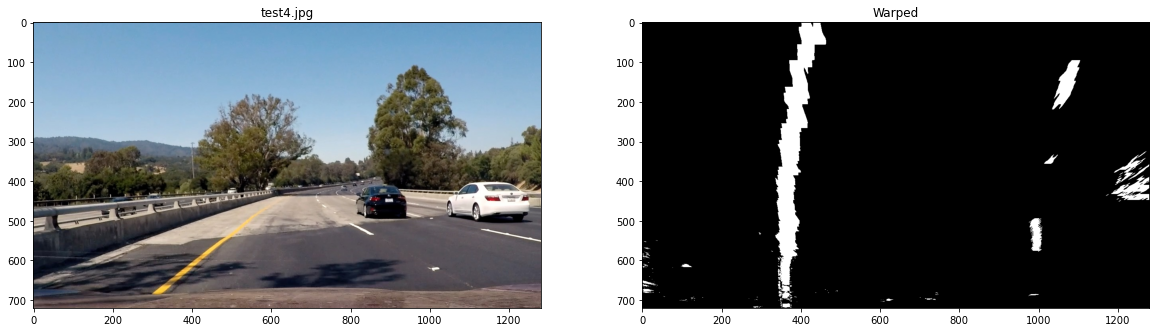

In [2]:
cameraData = utils.loadCameraData()

# Test images to create the color threasholds
test_image = cv2.imread("test_images/test4.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

warped = utils.find_edges_warped(test_image, cameraData)

utils.plot_side_by_side(test_image, warped, "test4.jpg", "Warped", gray=True)

In [3]:
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
non_zero   = warped.nonzero()
# X position of each pixel of the image that is not 0.
# Ex:
# [255, 0, 255] 
# [0, 255, 255]
# [0, 255, 255]
# Output for non_zero_x = [0, 1, 1, 2, 2, 2]
# REMEMBER: len(non_zero_x) is not the same as len(image) on x axis
non_zero_y = np.array(non_zero[0])
non_zero_x = np.array(non_zero[1])

# Set the width of the windows +/- margin
window_margin = 100

left_lane = {}
right_lane = {}

In [4]:
def find_lane_sliding_windows(warped):
    histogram = utils.hist(warped)
    
    midpoint = int(histogram.shape[0]//2)
    left_lane = {
        'base_point': np.argmax(histogram[:midpoint]),
    }
    right_lane = {
        'base_point': np.argmax(histogram[midpoint:]) + midpoint
    }

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    number_windows = 10
    # Height of windows - based on number_windows above and image shape
    window_height = int(warped.shape[0]//number_windows)
    # Set the minimum number of pixels that must be found. If not found, the window is recentered
    min_num_pix = 50

    # Current positions to be updated later for each window in nwindows
    left_lane['current_point']  = left_lane['base_point']
    right_lane['current_point'] = right_lane['base_point']

    # Create empty lists to receive left and right lane pixel indices
    left_lane['indices'] = []
    right_lane['indices'] = []

    # Create an output image with 3 dimensions with the binary warped image, to draw the windows and lane line
    out_img = np.dstack((warped, warped, warped))*255

    # Step through the windows one by one
    for idx_window in range(number_windows):
        # Identify window boundaries in x and y (and right and left)
        left_lane['window'] = {
            'top':    warped.shape[0] - ((idx_window+1) * window_height),
            'bottom': warped.shape[0] - (idx_window * window_height),
            'left':   left_lane['current_point'] - window_margin,
            'right':  left_lane['current_point'] + window_margin
        }
        right_lane['window'] = {
            'top':    warped.shape[0] - ((idx_window+1) * window_height),
            'bottom': warped.shape[0] - (idx_window * window_height),
            'left':   right_lane['current_point'] - window_margin,
            'right':  right_lane['current_point'] + window_margin,
        }

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (right_lane['window']['left'], right_lane['window']['bottom']),
                      (right_lane['window']['right'], right_lane['window']['top']),
                      (0, 255, 0), 
                      2)

        cv2.rectangle(out_img,
                      (left_lane['window']['left'], left_lane['window']['bottom']),
                      (left_lane['window']['right'], left_lane['window']['top']),
                      (0, 255, 0), 
                      2)

        # Identify the nonzero pixels in x and y within the window #
        # Doing that & operation, it's checked for every pixel if it is inside the window
        # It returns a array of indices of the pixels that is not zero on nonzero array
        left_lane['good_indices'] = (
            (non_zero_y < left_lane['window']['bottom']) &
            (non_zero_y >=  left_lane['window']['top'])  &
            (non_zero_x >= left_lane['window']['left'])  &
            (non_zero_x <  left_lane['window']['right'])
        ).nonzero()[0]

        right_lane['good_indices'] = (
            (non_zero_y < right_lane['window']['bottom']) &
            (non_zero_y >=  right_lane['window']['top']) &
            (non_zero_x >= right_lane['window']['left']) &
            (non_zero_x <  right_lane['window']['right'])
        ).nonzero()[0]

        teste = (
            (non_zero_y < left_lane['window']['bottom']) &
            (non_zero_y >=  left_lane['window']['top'])  &
            (non_zero_x >= left_lane['window']['left'])  &
            (non_zero_x <  left_lane['window']['right'])
        )

        left_lane['indices'].append(left_lane['good_indices'])
        right_lane['indices'].append(right_lane['good_indices'])

        if len(left_lane['good_indices']) > min_num_pix:
            left_lane['current_point']  = int(np.mean(non_zero_x[left_lane['good_indices']]))
        if len(right_lane['good_indices']) > min_num_pix:        
            right_lane['current_point'] = int(np.mean(non_zero_x[right_lane['good_indices']]))

    try:
        left_lane['indices'] = np.concatenate(left_lane['indices'])
        right_lane['indices'] = np.concatenate(right_lane['indices'])
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Save the points detected on every window to later fit a polynom 
    left_lane['x']  = non_zero_x[left_lane['indices']]
    left_lane['y']  = non_zero_y[left_lane['indices']]
    right_lane['x'] = non_zero_x[right_lane['indices']]
    right_lane['y'] = non_zero_y[right_lane['indices']]
    
    return left_lane['x'], left_lane['y'], right_lane['x'], right_lane['y'], out_img

In [5]:
def fit_polynomial(warped):
    left_x, left_y, right_x, right_y, out_img = find_lane_sliding_windows(warped)
    
    # coefficients from Ex: 2x² + 5x + 4 = [2, 5, 4]
    # np.polyfit finds the values that solves a n degree equation that describes the given points
    left_coefficients = np.polyfit(left_y, left_x, 2)
    right_coefficients = np.polyfit(right_y, right_x, 2)
    
    # generate y values to plot the lane line to later get x position and plot the line
    # Ex: f(y) = 2y² + 5y + 4. I'm here generating values for y
    # This function generate warped.shape[0](720) values from [0, warped.shape[0]-1(719)]
    y_values = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    # get the x values from the y values previsiously generated
    left_x_values  = left_coefficients[0] * y_values**2 + left_coefficients[1] * y_values + left_coefficients[2]
    right_x_values = right_coefficients[0] * y_values**2 + right_coefficients[1] * y_values + right_coefficients[2]
    
    left_curverature, right_curverature = utils.measure_curvature_pixels(left_coefficients, right_coefficients, y_values)
    print("left: {0} right: {1}".format(left_curverature, right_curverature))
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_y, left_x] = [255, 0, 0]
    out_img[right_y, right_x] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.figure(figsize = (15,15))
    plt.plot(left_x_values, y_values, color='yellow')
    plt.plot(right_x_values, y_values, color='yellow')

    return out_img

left: 2280.881638696167 right: 1643.8627856879298


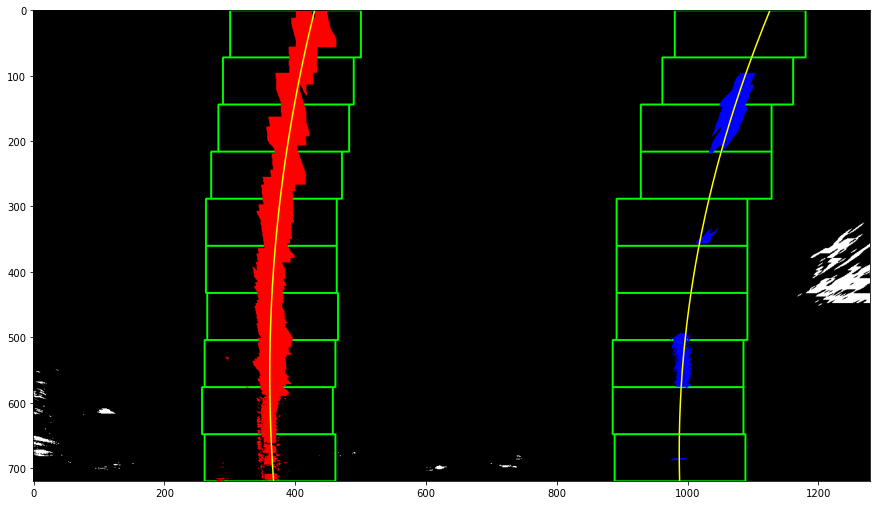

In [6]:
out_img = fit_polynomial(warped)
plt.imshow(out_img)
plt.show()

In [7]:
left_coefficients = np.array([2.20893785e-04, -2.46205796e-01,  4.29669511e+02])
right_coefficients = np.array([3.04487696e-04, -4.11122644e-01, 1.12603645e+03])

In [8]:
def search_around_poly(warped):
    left_lane['indices'] = (
        (non_zero_x > (left_coefficients[0]*(non_zero_y**2) + left_coefficients[1]*non_zero_y + left_coefficients[2] - window_margin)) & 
        (non_zero_x < (left_coefficients[0]*(non_zero_y**2) + left_coefficients[1]*non_zero_y + left_coefficients[2] + window_margin))
    )
    right_lane['indices'] = (
        (non_zero_x > (right_coefficients[0]*(non_zero_y**2) + right_coefficients[1]*non_zero_y + right_coefficients[2] - window_margin)) & 
        (non_zero_x < (right_coefficients[0]*(non_zero_y**2) + right_coefficients[1]*non_zero_y + right_coefficients[2] + window_margin))
    )
    
    left_lane['x'] = non_zero_x[left_lane['indices']]
    left_lane['y'] = non_zero_y[left_lane['indices']]
    right_lane['x'] = non_zero_x[right_lane['indices']]
    right_lane['y'] = non_zero_y[right_lane['indices']]
    
    # Fit new polynomials
    left_x_values, right_x_values, y_values = utils.fit_polynomial(left_lane['x'], left_lane['y'], 
                                                              right_lane['x'], right_lane['y'], warped.shape)
    
    left_curverature, right_curverature = utils.measure_curvature_pixels(left_coefficients, right_coefficients, y_values)
    
    print("left: {0} right: {1}".format(left_curverature, right_curverature))
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[non_zero_y[left_lane['indices']], non_zero_x[left_lane['indices']]] = [255, 0, 0]
    out_img[non_zero_y[right_lane['indices']], non_zero_x[right_lane['indices']]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_lane['window1'] = np.array(
        [np.transpose(np.vstack([left_x_values-window_margin, y_values]))]
    )
    left_lane['window2'] = np.array(
        [np.flipud(np.transpose(np.vstack([left_x_values+window_margin, y_values])))]
    )
    left_lane['points']  = np.hstack((left_lane['window1'], left_lane['window2']))
    
    right_lane['window1'] = np.array(
        [np.transpose(np.vstack([right_x_values-window_margin, y_values]))]
    )
    right_lane['window2'] = np.array(
        [np.flipud(np.transpose(np.vstack([right_x_values+window_margin, y_values])))]
    )
    right_lane['points']  = np.hstack((right_lane['window1'], right_lane['window2']))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_lane['points']]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_lane['points']]), (0,255, 0))
    # Soma ponderada
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.figure(figsize=(15,15))
    plt.plot(left_x_values, y_values, color='yellow')
    plt.plot(right_x_values, y_values, color='yellow')
    ## End visualization steps ##
    
    return result

left: 2280.881635836962 right: 1643.8627850797868


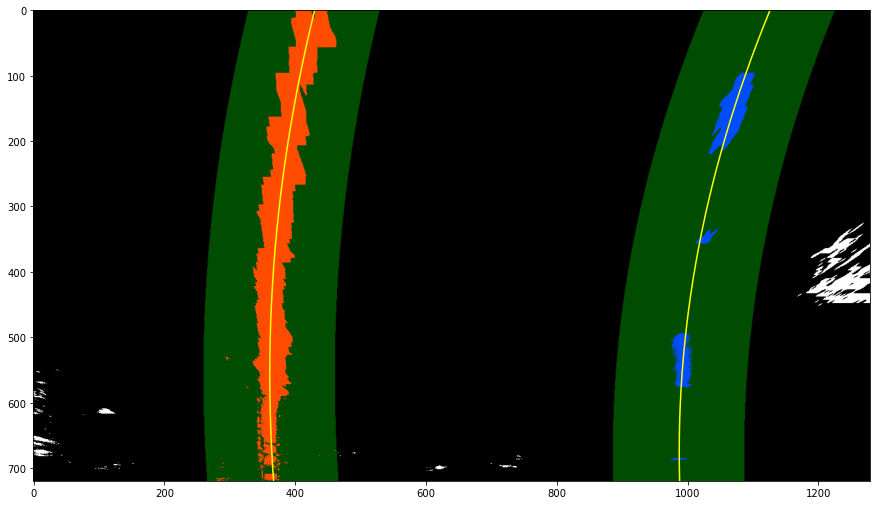

In [9]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)
plt.show()